In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math


# Step 1: Generate the data 
I'm aiming to generate 100000 datapoints from a Gaussian mixture model of k = 15 components. For simplicity, each datapoint is a scalar (1-dimension). 
To make it more realistic, I will random the weight of each component.

In [2]:
n = 100000 # Number of datapoints
k = 15 # Number of components

# Randomising the weights
weights = np.random.uniform(low = 0.75, high = 1, size=(k, ))
weights = weights / np.sum(weights) 
assert abs(np.sum(weights) - 1) < 0.0000001 # Ensuring a convex linear combination

# Decide which component we will sample from
mixture_index = np.random.choice(k, size = n, replace = True, p = weights)
assert mixture_index.shape == (n, )

# Decide the random mean and variance of all 100 components
mean = np.random.uniform(low=-12.5, high=12.5, size=(k, ))
variance = np.random.uniform(low=0.75, high=1.5, size=(k, ))


In [3]:
# Generate data using numpy for efficiency
data = np.fromiter((np.random.normal(loc = mean[index], scale = np.sqrt([variance[index]])[0]) for index in mixture_index), float)
assert data.shape == (n, )

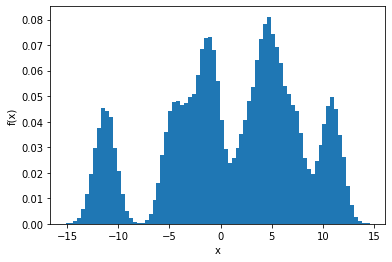

In [4]:
plt.hist(data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

# Step 2: The traditional EM algorithm
The algorithm includes finding the probability of each point belonging to each component, then tune the mean and variance of each component according the the calculated probabilities. 

In [5]:

# First, define a way to calculate pdf 
# This function is actually not used due to its low efficiency. See function calculate_p_matrix below
def pdf(x, input_mean, input_var):
    return math.exp(-0.5 * ((x - input_mean) ** 2 ) / input_var) / (math.sqrt(2 * math.pi * input_var))

# Test the function
assert pdf(0, 0, 1) == 0.3989422804014327
assert pdf(0.5, 0, 1) == 0.3520653267642995


In [6]:
# Using numpy to calculate pdf
# Note that this p matrix is not yet normalised
def calculate_p_matrix(x, input_mean, input_var, input_weight):
    # Duplicate data so dimensions work out
    mean_matrix = np.tile(input_mean, (len(x), 1)).T
    variance_matrix = np.tile(input_var, (len(x), 1)).T
    weight_matrix = np.tile(input_weight, (len(x), 1)).T
    
    # PDF calculation
    p_matrix = weight_matrix * np.exp(-0.5 * np.power(x - mean_matrix, 2) / variance_matrix) / (np.sqrt(2 * np.pi * variance_matrix))
    
    p_matrix = p_matrix.transpose(1, 0)
    
    return p_matrix


In [7]:
# Define a metric to evaluate our return from EM alg.
# Hardcoded P_value to save time

# Old implementation
old_P_value = np.zeros((n,))
for i in range(n):
    for j in range(k):
        old_P_value[i] += weights[j] * pdf(data[i], mean[j], variance[j])


# New implementation with numpy, more efficient
P_value = np.sum(calculate_p_matrix(data, mean, variance, weights), axis = 1)
   
print("new", P_value)
print("old", old_P_value)

new [0.03701252 0.04243266 0.03601337 ... 0.04932846 0.03027117 0.04737035]
old [0.03701252 0.04243266 0.03601337 ... 0.04932846 0.03027117 0.04737035]


In [8]:

# KL divergence is an integral from -inf to +inf, in this case, I only use the n datapoints that we already generated.
# The addition of - P + Q was inspired by scipy's implementation of KL divergence. Apparently, it prevents KL divergence from going negative
def KL_div(pred_mean, pred_variance, pred_weights):
    # Old implementation
    """KL_divergence = 0
    for i in range(n):
        Q_value = 0
        for j in range(k):
            Q_value += pred_weights[j] * pdf(data[i], pred_mean[j], pred_variance[j])
            #P_value += weights[j] * pdf(data[i], mean[j], variance[j])
        KL_divergence += P_value[i] * math.log(P_value[i]/Q_value, math.e) - P_value[i] + Q_value"""
    
    
    # New implementation
    Q_value = np.sum(calculate_p_matrix(data, pred_mean, pred_variance, pred_weights), axis = 1)
    
    KL_divergence = np.sum(P_value * np.log(P_value / Q_value) - P_value + Q_value)
    
    return KL_divergence
    
assert KL_div(mean, variance, weights) == 0



In [9]:
# This implementation is based on Dr. Martha White's notes for CMPUT367, page 107. 

"""scaling_factor_plot = [[] for j in range(k)]
print(scaling_factor_plot)
"""


# Starts with random means, variances and weights
predicted_mean_traditional = np.random.uniform(low=-5, high=5, size=(k, ))
predicted_variance_traditional = np.random.uniform(low=0.5, high=5, size=(k, ))
predicted_weights_traditional = np.random.random(size=(k, ))
predicted_weights_traditional = predicted_weights_traditional / np.sum(predicted_weights_traditional) #normalising

def traditional_EM():

    
    global predicted_mean_traditional, predicted_variance_traditional, predicted_weights_traditional
    divergence_plot = [] # Array for plotting later
    counter = 0 # Count iteration for printing divergence
    
    KL_divergence = KL_div(predicted_mean_traditional, predicted_variance_traditional, predicted_weights_traditional)
    print("kl div:", KL_divergence)
    prev_divergence = math.inf
    
    
    
    while prev_divergence - KL_divergence > 0.0001 and KL_divergence > 0:
        
        # This is the old implementation using python loops. I need to redo this part in numpy to optimise bc it takes too much time.
        """for i in range(n):
            denominator_sum = 0
            for j in range(k):
                probability_matrix[i, j] = predicted_weights[j] * pdf(data[i], predicted_mean[j], predicted_variance[j])
            
            denominator_sum = np.sum(probability_matrix[i, :])
            
            probability_matrix[i, :] = probability_matrix[i, :] / denominator_sum"""
        
        probability_matrix = calculate_p_matrix(data, predicted_mean_traditional, predicted_variance_traditional, predicted_weights_traditional)
        # Normalise
        probability_matrix = probability_matrix / np.sum(probability_matrix, axis = 1, keepdims=True)
        
        """for j in range(k):
            normalised_p_matrix[:, j] = probability_matrix[:, j] / np.sum(probability_matrix[:, j])
            scaling_factor_plot[j].append(np.sum(probability_matrix[:, j]))"""
            
        normalised_p_matrix = probability_matrix / np.sum(probability_matrix, axis = 0, keepdims=True)
        
        
        # Maximisation step
        predicted_weights_traditional = (1/n) * np.sum(probability_matrix, axis = 0)
        
        mean_matrix = (data * normalised_p_matrix.T).T
        predicted_mean_traditional = np.sum(mean_matrix, axis = 0)

        predicted_variance_traditional = np.sum(np.multiply(np.power(np.tile(data, (k, 1)).T - predicted_mean_traditional, 2), normalised_p_matrix), axis = 0)
        
        
        diff = prev_divergence - KL_divergence
        prev_divergence = KL_divergence
        KL_divergence = KL_div(predicted_mean_traditional, predicted_variance_traditional, predicted_weights_traditional)
        
        if counter % 15 == 0:
            print("kl div:", KL_divergence, " |  iter:", counter, " |  difference vs the prev iter:", diff)
            
            
        divergence_plot.append(KL_divergence)
        counter += 1
    return divergence_plot



In [10]:
# Will take abt 5 to 10 minutes to run and converge
divergence_plot = traditional_EM()

kl div: 5458.433301781226
kl div: 361.60194451609357  |  iter: 0  |  difference vs the prev iter: inf
kl div: 81.9472432476312  |  iter: 15  |  difference vs the prev iter: 1.7499893858746702
kl div: 56.61206693776511  |  iter: 30  |  difference vs the prev iter: 1.8610506688882325
kl div: 23.72212568012575  |  iter: 45  |  difference vs the prev iter: 2.365576111707849
kl div: 6.148227446140358  |  iter: 60  |  difference vs the prev iter: 0.44718110497620245
kl div: 3.1930106711112254  |  iter: 75  |  difference vs the prev iter: 0.09371032913486266
kl div: 2.592033628899608  |  iter: 90  |  difference vs the prev iter: 0.021278891036708103
kl div: 2.395762011723056  |  iter: 105  |  difference vs the prev iter: 0.009889862952941808
kl div: 2.283216776508712  |  iter: 120  |  difference vs the prev iter: 0.006216080879122732
kl div: 2.209975655639958  |  iter: 135  |  difference vs the prev iter: 0.004170299010805234
kl div: 2.1555855592558504  |  iter: 150  |  difference vs the prev

In [11]:
print("----- TARGET DISTRIBUTION ------")
for i in range(k):
    print("component mean:", mean[i], "| variance:", variance[i], "| weight:", weights[i])

print("----- LEARNED DISTRIBUTION ------")
for i in range(k):
    print("component mean:", predicted_mean_traditional[i], "| variance:", predicted_variance_traditional[i], "| weight:", predicted_weights_traditional[i])

----- TARGET DISTRIBUTION ------
component mean: -11.672613653432812 | variance: 1.0318433374469609 | weight: 0.05922185651796089
component mean: -1.6074978744599928 | variance: 1.4333473867299162 | weight: 0.07063756819430572
component mean: 4.094745312277848 | variance: 1.118858920609918 | weight: 0.061811751433560595
component mean: 2.0572158547178674 | variance: 0.9587485734299261 | weight: 0.06393055931356285
component mean: 5.63144232576137 | variance: 1.4184678949321632 | weight: 0.06587811082683495
component mean: 4.091217942458851 | variance: 1.1522444150442825 | weight: 0.06951439624583526
component mean: 11.223438473589585 | variance: 0.8535344460937175 | weight: 0.07267766848694315
component mean: -3.812700078255112 | variance: 1.1586812443684433 | weight: 0.06103108899649268
component mean: 7.370933412557804 | variance: 0.8590739652181271 | weight: 0.07226443611739235
component mean: -4.854918987713738 | variance: 0.9630536117705006 | weight: 0.07158472816691576
component 

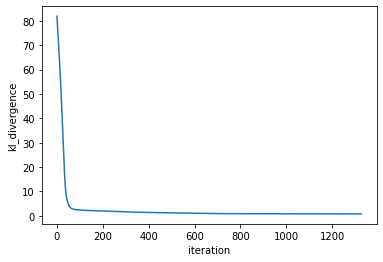

In [12]:
plt.plot([i for i in range(len(divergence_plot[15:]))], divergence_plot[15:])
plt.xlabel("iteration")
plt.ylabel("kl_divergence")
plt.show()


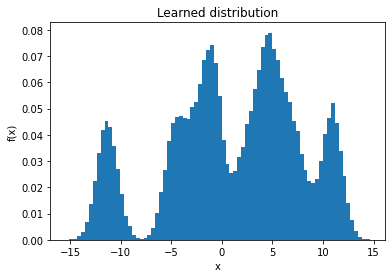

In [13]:
learned_mixture_index = np.random.choice(k, size = n, replace = True, p = predicted_weights_traditional)
learned_data = np.fromiter((np.random.normal(loc = predicted_mean_traditional[index], scale = np.sqrt([predicted_variance_traditional[index]])[0]) for index in learned_mixture_index), float)
assert data.shape == (n, )

plt.hist(learned_data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Learned distribution")
plt.show()

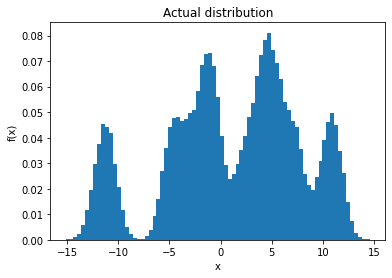

In [14]:
plt.hist(data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Actual distribution")
plt.show()

# Dynamic-update EM

The traditional EM algorithm needs all the datapoint before making any changes to the weights, means and variances. From the idea of reinforcement learning, what if we update every time we see a datapoint (or a batch of datapoints)? In RL, dynamic programming value update will speed up the covergence rate significantly, and is proven to be an unbiased estimator of the actual value function. 

# 2a. Constant stepsize 
Currently, it is not converging. I have not figured out why.

In [20]:
predicted_mean_dynamic = np.random.uniform(low=-5, high=5, size=(k, ))
predicted_variance_dynamic = np.random.uniform(low=0.5, high=5, size=(k, ))
predicted_weights_dynamic = np.random.random(size=(k, ))
predicted_weights_dynamic = predicted_weights_dynamic / np.sum(predicted_weights_dynamic) 
def dynamicEM():
    global predicted_mean_dynamic, predicted_variance_dynamic, predicted_weights_dynamic
    divergence_plot = [] # Array for plotting later
    counter = 0 # Count iteration for printing divergence
    
    KL_divergence = KL_div(predicted_mean_dynamic, predicted_variance_dynamic, predicted_weights_dynamic)
    print("kl div:", KL_divergence)
    prev_divergence = math.inf
    
    
    while True:#prev_divergence - KL_divergence > 0.0001 and KL_divergence > 0:
        
        # This is the old implementation using python loops. I need to redo this part in numpy to optimise bc it takes too much time.
        """for i in range(n):
            denominator_sum = 0
            for j in range(k):
                probability_matrix[i, j] = predicted_weights[j] * pdf(data[i], predicted_mean[j], predicted_variance[j])
            
            denominator_sum = np.sum(probability_matrix[i, :])
            
            probability_matrix[i, :] = probability_matrix[i, :] / denominator_sum"""
        
        index = counter % 1000
        probability_matrix = calculate_p_matrix(data[index:(index + 1) * 1000], predicted_mean_dynamic, predicted_variance_dynamic, predicted_weights_dynamic)
        # Normalise
        probability_matrix = probability_matrix / np.sum(probability_matrix, axis = 1, keepdims=True)
        
        """for j in range(k):
            normalised_p_matrix[:, j] = probability_matrix[:, j] / np.sum(probability_matrix[:, j])
            scaling_factor_plot[j].append(np.sum(probability_matrix[:, j]))"""
            
        normalised_p_matrix = probability_matrix / np.sum(probability_matrix, axis = 0, keepdims=True)
        
        
        # Maximisation step
        predicted_weights_dynamic = (1/n) * np.sum(probability_matrix, axis = 0)
        
        mean_matrix = (data[index:(index + 1) * 1000] * normalised_p_matrix.T).T
        predicted_mean_dynamic = np.sum(mean_matrix, axis = 0)

        predicted_variance_dynamic = np.sum(np.multiply(np.power(np.tile(data[index:(index + 1) * 1000], (k, 1)).T - predicted_mean_dynamic, 2), normalised_p_matrix), axis = 0)
        
        
        diff = prev_divergence - KL_divergence
        prev_divergence = KL_divergence
        KL_divergence = KL_div(predicted_mean_dynamic, predicted_variance_dynamic, predicted_weights_dynamic)
        
        if counter % 15 == 0:
            print("kl div:", KL_divergence, " |  iter:", counter, " |  difference vs the prev iter:", diff)
            
            
        divergence_plot.append(KL_divergence)
        counter += 1
    return divergence_plot

divergence_plot = dynamicEM()

kl div: 7133.423675537747
kl div: 19014.269964932835  |  iter: 0  |  difference vs the prev iter: inf
kl div: 5365.6432006168225  |  iter: 15  |  difference vs the prev iter: 334.10354517076576
kl div: 2468.742007157912  |  iter: 30  |  difference vs the prev iter: 124.67371247518577
kl div: 1183.9277537161295  |  iter: 45  |  difference vs the prev iter: 63.644975710747985
kl div: 524.9927187302486  |  iter: 60  |  difference vs the prev iter: 33.133490988560425
kl div: 176.5709547203627  |  iter: 75  |  difference vs the prev iter: 16.95742467008614
kl div: 25.708324846439254  |  iter: 90  |  difference vs the prev iter: 5.945340403249794
kl div: 3.38153040706313  |  iter: 105  |  difference vs the prev iter: 0.030334593352160155
kl div: 3.011065622347325  |  iter: 120  |  difference vs the prev iter: 0.020887958939204587
kl div: 2.763656771568895  |  iter: 135  |  difference vs the prev iter: 0.014137593021811057
kl div: 2.5961763756765412  |  iter: 150  |  difference vs the prev it

KeyboardInterrupt: 